In [1]:
import numpy as np
import pandas as pd

import time, warnings
import datetime as dt

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

import squarify
from scipy.stats import norm
warnings.filterwarnings("ignore")

In [2]:
retail_df = pd.read_csv('C:/Users/prath/Downloads/proj_data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
retail_df[retail_df['CustomerID'] == 12747]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [4]:
retail_df.shape

(541909, 8)

In [5]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df.shape

(531285, 8)

In [6]:
retail_df.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_df.shape

(397924, 8)

In [7]:
retail_df = retail_df[retail_df['InvoiceDate']>= "2010-12-09"]
retail_df.shape

(199198, 8)

In [8]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_df['InvoiceNo'].nunique())
print("Number of products bought: ",retail_df['StockCode'].nunique())
print("Number of customers:", retail_df['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_df['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Summary..
Number of transactions:  9786
Number of products bought:  3324
Number of customers: 3165
Percentage of customers NA:  0.0 %


## RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services. 

RECENCY (R): Days since last purchase

FREQUENCY (F): Total number of purchases

MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

## RECENCY

To calculate recency, we need to choose a date point from which we evaluate how many days ago was the customer last purchase.

In [9]:
#last date available in our dataset
retail_df['InvoiceDate'].max()

'9/9/2011 9:52'

In [10]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [11]:
#create a new column called date which contains the date of invoice only
retail_df['Date'] = pd.DatetimeIndex(retail_df['InvoiceDate']).date
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105336,545220,48194,DOORMAT HEARTS,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,3/1/2011 8:30,1.65,14620,United Kingdom,2011-03-01
105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,3/1/2011 8:30,4.95,14620,United Kingdom,2011-03-01
105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,3/1/2011 8:30,3.75,14620,United Kingdom,2011-03-01


In [12]:
#group by customers and check last date of purshace
recency_df = retail_df.groupby(by='CustomerID', as_index=False)['Date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12347,2011-08-02
1,12348,2011-09-25
2,12352,2011-09-28
3,12353,2011-05-19
4,12354,2011-04-21


In [13]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [14]:
recency_df

,CustomerID,LastPurshaceDate,Recency
0,12347,2011-08-02,129
1,12348,2011-09-25,75
2,12352,2011-09-28,72
3,12353,2011-05-19,204
4,12354,2011-04-21,232
...,...,...,...
3160,18280,2011-03-07,277
3161,18281,2011-06-12,180
3162,18282,2011-08-05,126
3163,18283,2011-09-05,95


In [15]:
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

## Frequency

Frequency helps us to know how many times a customer purchased from us. To do that we need to check how many invoices are registered by the same customer.

In [16]:
# drop duplicates
retail_df_copy = retail_df
retail_df_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = retail_df_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12347,3
1,12348,2
2,12352,6
3,12353,1
4,12354,1


## Monetory

Monetary attribute answers the question: How much money did the customer spent over time?

To do that, first, we will create a new column total cost to have the total price per invoice.

In [17]:
retail_df['TotalCost'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [18]:
monetary_df = retail_df.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12347,55.16
1,12348,250.00
2,12352,498.80
3,12353,19.90
4,12354,20.80


## Create RFM Table

In [19]:
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12347,129,3
1,12348,75,2
2,12352,72,6
3,12353,204,1
4,12354,232,1


In [20]:
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
rfm_df.set_index('CustomerID',inplace=True)

rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,129,3,55.16
12348,75,2,250.00
12352,72,6,498.80
12353,204,1,19.90
12354,232,1,20.80


## RFM Table Correctness verification

In [21]:
retail_df[retail_df['CustomerID']=='12820']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,TotalCost
360567,568236,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE,4,9/26/2011 11:49,3.75,12820,United Kingdom,2011-09-26,15.0


In [22]:
(now - dt.date(2011,9,26)).days == 74

True

In [23]:
temp_df[temp_df['CustomerID'] == '12820']

,CustomerID,Recency,Frequency
264,12820,74,1


## Customer segments with RFM Model

The simplest way to create customers segments from RFM Model is to use** Quartiles**. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

### RFM Quartiles

In [24]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,85.0,1.0,16.5
0.50,117.0,2.0,35.7
0.75,182.0,3.0,96.5


In [25]:
quantiles.to_dict()

{'Recency': {0.25: 85.0, 0.5: 117.0, 0.75: 182.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'Monetary': {0.25: 16.5, 0.5: 35.7, 0.75: 96.5}}

### Creation of RFM Segments

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [26]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [27]:
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [28]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12347,129,3,55.16,2,3,3
12348,75,2,250.00,4,2,4
12352,72,6,498.80,4,4,4
12353,204,1,19.90,1,1,2
12354,232,1,20.80,1,1,2


Now that we have the score of each customer, we can represent our customer segmentation. First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [29]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12347,129,3,55.16,2,3,3,233
12348,75,2,250.00,4,2,4,424
12352,72,6,498.80,4,4,4,444
12353,204,1,19.90,1,1,2,112
12354,232,1,20.80,1,1,2,112


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

Let's see who are our** Champions** (best customers).

In [30]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
18102,72,34,26632.62,4,4,4,444
17949,70,32,22504.73,4,4,4,444
17450,70,28,18009.06,4,4,4,444
16029,80,39,15119.49,4,4,4,444
16013,70,24,10402.34,4,4,4,444
14646,78,37,7221.50,4,4,4,444
14911,70,111,7123.52,4,4,4,444
12901,81,20,5915.66,4,4,4,444
13798,72,34,4648.80,4,4,4,444


In [31]:
rfm_segmentation['RFM_Sum'] = rfm_segmentation[['F_Quartile','R_Quartile','M_Quartile']].sum(axis=1)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,RFM_Sum
CustomerID,,,,,,,,
12347,129,3,55.16,2,3,3,233,8
12348,75,2,250.00,4,2,4,424,10
12352,72,6,498.80,4,4,4,444,12
12353,204,1,19.90,1,1,2,112,4
12354,232,1,20.80,1,1,2,112,4


In [32]:
def rfm_level(df):
    if df['RFM_Sum'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Sum'] >= 8) and (df['RFM_Sum'] < 9)):
        return 'Champions'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 6) and (df['RFM_Sum'] < 7)):
        return 'Potential'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 6)):
        return 'Promising'
    elif ((df['RFM_Sum'] >= 4) and (df['RFM_Sum'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm_segmentation['RFM_Level'] = rfm_segmentation.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,RFM_Sum,RFM_Level
CustomerID,,,,,,,,,
12347,129,3,55.16,2,3,3,233,8,Champions
12348,75,2,250.00,4,2,4,424,10,Can't Loose Them
12352,72,6,498.80,4,4,4,444,12,Can't Loose Them
12353,204,1,19.90,1,1,2,112,4,Needs Attention
12354,232,1,20.80,1,1,2,112,4,Needs Attention


In [33]:
rfm_level_agg = rfm_segmentation.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them      93.1       6.3    431.9  1075
Champions            111.4       2.3     87.6   285
Loyal                124.8       1.8     68.4   355
Needs Attention      199.0       1.1     16.6   382
Potential            134.2       1.5     61.9   430
Promising            163.2       1.2     26.8   328
Require Activation   233.5       1.0      9.8   310


## How many customers do we have in each segment?

#### Best Customers

In [34]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Best Customers:  242


#### Loyal Customers

In [35]:
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))

Loyal Customers:  760


#### Big Spenders

In [36]:
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))

Big Spenders:  791


#### Almost Lost

In [37]:
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))

Almost Lost:  63


#### Lost Customers

In [38]:
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))

Lost Customers:  7


#### Lost Cheap Customers

In [39]:
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Lost Cheap Customers:  310


## RFM Segmentation Visualization

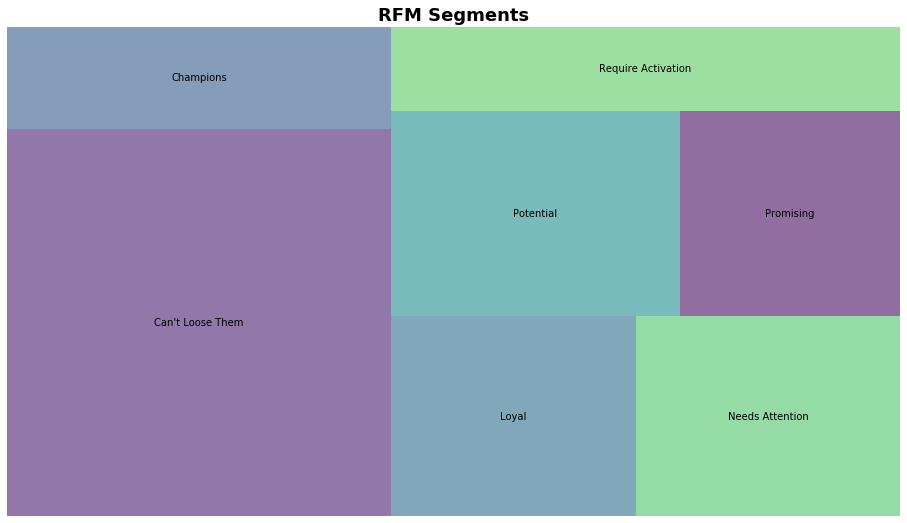

In [40]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

## Plot RFM distributions

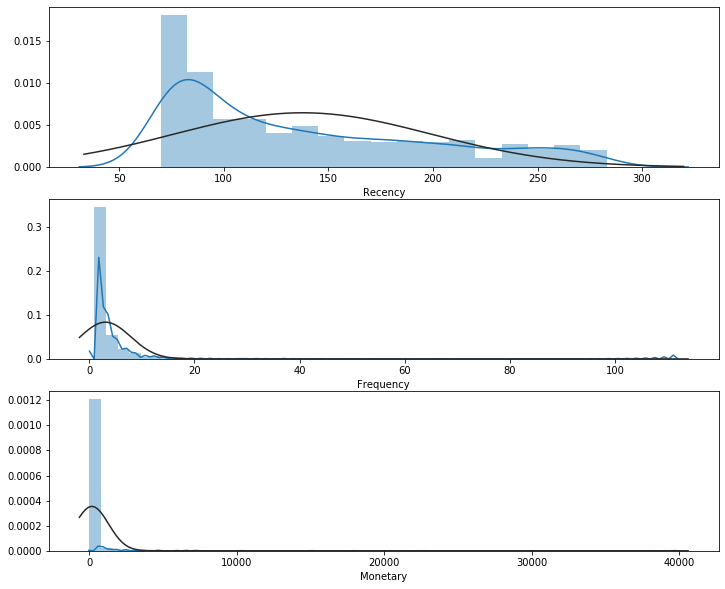

In [41]:
plt.figure(figsize=(12,10))
# distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_segmentation['Recency'],fit=norm)
# distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_segmentation['Frequency'],fit=norm)
# distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_segmentation['Monetary'],fit=norm)

plt.show()

## Cohort Analysis

In [42]:
df = pd.read_csv('C:/Users/prath/Downloads/proj_data.csv', encoding = "ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [43]:
df = df[df['Quantity']>0]
df.shape

(531285, 8)

In [44]:
df.dropna(subset=['CustomerID'],how='all',inplace=True)
df.shape

(397924, 8)

In [45]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice'] ## add Revenue (Qty * UnitPrice) column
df['CustomerID'] = df['CustomerID'].astype('int64') #change format CustomerID

In [46]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [47]:
def get_month(x): return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

In [48]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [49]:
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [50]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

In [51]:
df['CohortIndex'] = years_diff * 12 + months_diff + 1

In [52]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [53]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

In [54]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Retention Rate

In [55]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(2) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,37.0,32.0,38.0,36.0,40.0,36.0,35.0,35.0,40.0,37.0,50.0,27.0
2011-01-01,100.0,22.0,27.0,23.0,32.0,29.0,25.0,24.0,30.0,33.0,36.0,12.0,NaN
2011-02-01,100.0,19.0,19.0,28.0,27.0,25.0,25.0,28.0,25.0,31.0,7.0,NaN,NaN
2011-03-01,100.0,15.0,25.0,20.0,22.0,17.0,27.0,23.0,28.0,9.0,NaN,NaN,NaN
2011-04-01,100.0,21.0,20.0,21.0,20.0,23.0,22.0,26.0,7.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.0,17.0,21.0,23.0,26.0,10.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.0,16.0,26.0,23.0,33.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.0,21.0,22.0,27.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.0,25.0,24.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


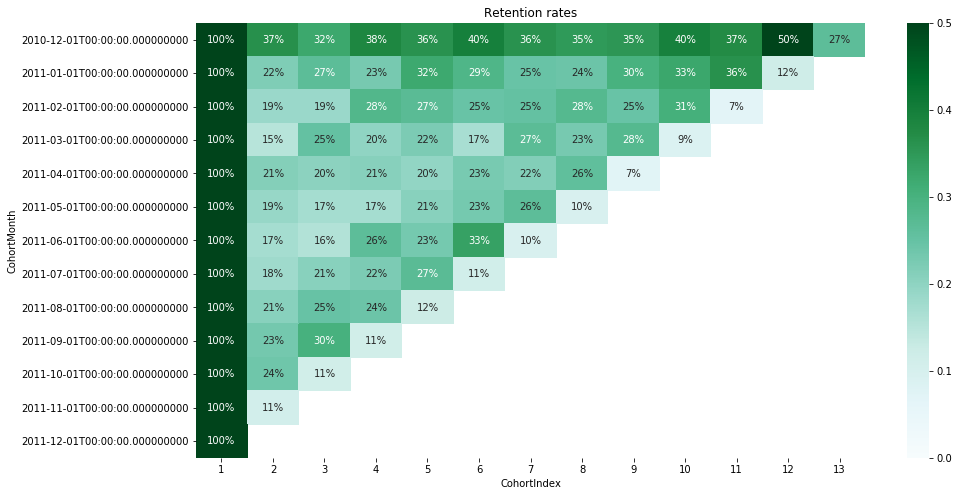

In [56]:
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,
annot = True,
fmt = '.0%',
vmin = 0.0,
vmax = 0.5,
cmap = 'BuGn')
plt.show()

#### Purchase Frequency

In [57]:
purchase_frequency=sum(rfm_df['Recency'])/rfm_df.shape[0]
purchase_frequency

137.6837282780411

#### Calculate Repeat Rate and Churn Rate

In [59]:
repeat_rate=rfm_df[rfm_df.Recency > 1].shape[0]/rfm_df.shape[0]
repeat_rate

1.0